In [21]:
import os, math, time, random, pickle
from itertools import count
from collections import deque, OrderedDict, namedtuple
from copy import deepcopy

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import gym
from gym import spaces

import torch
from torch import nn, optim, autograd
from torch.nn import functional as F

import torchvision
from torchvision import transforms as T

In [22]:
DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
env= gym.make('Breakout-v0')

In [24]:
def preprocess_frame(observation: np.array, frame_dim: tuple) -> torch.tensor:
    '''
    Processes the provided frame to a model compatible size

    Input:
        observation: np.array - Frame from the environment
        frame_dim: tuple - Required frame size; should be the same as the planned CNN input dimension
    Returns:
        torch.tensor - Resized, clipped, & grayed frame with dimensions (1, 1 [grayscale channel], *frame_dim)
    '''

    # Converts RGB frame (Height, Width, Channels) to Grayscale (Height, Width)
    observation= cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)

    height, width= observation.shape
    
    # Clips unnecessary visual features - In this case, clips the score area, frames, & black bottom line
    observation= observation[int(height*0.15):int(height*0.93), int(width*0.05):int(width*0.95)]

    # Normalizing pixel values
    observation= np.ascontiguousarray(observation, dtype= np.float32) / 255

    # Function to resize frame to required dimension & returns as a tensor
    resize_func= T.Compose([T.ToPILImage(), T.Resize(frame_dim, interpolation= Image.CUBIC), T.ToTensor()])

    return resize_func(observation).unsqueeze(0)

In [25]:
experience= namedtuple('experience', ['state', 'action', 'next_state', 'reward', 'done'])

class Memory:
    def __init__(self, capacity) -> None:
        '''
        Creates a memory buffer for the agent

        Input:
            capacity: int - Maximum memory size
        '''
        
        self.capacity= capacity
        self.memory= deque(maxlen= self.capacity)

    def memorize(self, observation: tuple) -> None:
        '''
        Memorizes an experience to the memory (i.e.) adds an observation to the memory buffer

        Input:
            observation: tuple - Contains agent's current state, action performed, agent's next state, 
            reward achieved, and done status
        '''

        self.memory.append(experience(*observation))

    def sample(self, batch_size) -> tuple:
        '''
        Samples a random batch of experiences from the memory

        Input:
            batch_size: int - Number of experiences needed to train the model
        Returns:
            tuple - Set of states, actions, next_states, rewards, and dones
        '''

        experiences= random.sample(self.memory, batch_size)

        states= [i.state for i in experiences]
        actions= [i.action for i in experiences]
        next_states= [i.next_state for i in experiences]
        rewards= [i.reward for i in experiences]
        dones= [i.done for i in experiences]

        return (states, actions, next_states, rewards, dones)

    def __len__(self):
        '''
        Returns the size of the filled memory
        '''

        return len(self.memory)

In [26]:
class DQN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, conv_net: bool= False, n_hidden: int= 1, hidden_width: int= 128) -> None:
        '''
        Builds a NN for the required specifications

        Input:
            input_dim: tuple of int - Dimension of the input data
            output_dim: int - Number of Q-values to be determined (i.e.) Q-value for each action
            conv_net: bool - If the environment requires CNN or not
            n_hidden: int - Number of hidden layers
            hidden_width: int - Number of nodes in each hidden layer
        '''

        super(DQN, self).__init__()
        
        self.input_dim= (84, 84)
        self.n_hidden= n_hidden
        self.hidden_layers= list()
        self.hidden_width= hidden_width
        self.output_dim=output_dim
        self.conv_net= conv_net

        self.device= DEVICE

        if self.conv_net:
            self.build_cnn()
        else:
            self.build_nn()

    def build_nn(self) -> None:
        '''
        Builds a NN for the given specifications
        '''

        for each_layer in range(self.n_hidden):
            self.hidden_layers.append(nn.Linear(self.hidden_width, self.hidden_width))
            self.hidden_layers.append(nn.ReLU())

        self.model= nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_width), 
            nn.ReLU(), 
            *self.hidden_layers, 
            nn.Linear(self.hidden_width, self.output_dim)
        )

        if self.device == 'cuda':
            self.model.cuda()

    def build_cnn(self) -> None:
        '''
        Builds a CNN for the given specifications
        '''

        # Convolutional Neural Network (CNN) layers
        self.cnn= nn.Sequential(
            nn.Conv2d(self.input_dim, 32, kernel_size= 8, stride= 4), 
            nn.ReLU(), 
            nn.Conv2d(32, 64, kernel_size= 4, stride= 2), 
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=3, stride= 1), 
            nn.ReLU()
        )

        # Building fully connected hidden layers
        for each_layer in range(self.n_hidden):
            self.hidden_layers.append(nn.Linear(self.hidden_width, self.hidden_width))
            self.hidden_layers.append(nn.ReLU())

        # Calculating fully connected layer input dimension
        self.cnn_out_dim= self.cal_cnn_out()

        # Fully Connected Network (FCN) layers
        self.fcn= nn.Sequential(
            nn.Linear(self.cnn_out_dim, self.hidden_width), 
            nn.ReLU(), 
            *self.hidden_layers, 
            nn.Linear(self.hidden_width, self.output_dim)
        )

        # If GPU available, move model to GPU for faster processing
        if self.device == 'cuda':
            self.cnn.cuda()
            self.fcn.cuda()

    def cal_cnn_out(self):
        '''
        Output size of the CNN model can be using the following formula,
        size= ((w - k + 2p) / s)+1 where, w (width) is the input dimension; k is the kernel size;
        p is the padding size; and s is the stride value.

        But another alternative method is to propagate an empty tensor through the CNN and find the
        output size from the model's output.

        Input:
            input_dim: tuple of int - Dimension of the input data Eg: (1, 4 [frame stack], 
            84 [frame height], 84 [frame width])
        Returns:
            int - Number of outputs for the built CNN model
        '''
        return self.cnn(torch.zeros(*self.input_dim)).flatten().shape[0]

    def predict(self, tensor_input: torch.tensor):
        '''
        Predicts the Q-values for the action space based on given state
        '''
        if self.conv_net:
            # CNN Prediction
            cnn_pred= self.cnn(tensor_input)
            return self.fcn(cnn_pred.view(cnn_pred.size(0), -1))
        else:
            # NN Prediction
            return self.model(tensor_input)

In [27]:
class DQNAgent:
    def __init__(self, env, conv_net: bool, env_name: str, learning_rate: float= 0.001, discount_factor: float= 0.999, tau: float= 0.01, memory_size: int= 10000) -> None:
        '''
        Double Deep Q-Learning Agent

        Input:
            env: Instance of the environement
            conv_net: bool - If the environment requires CNN or not
            env_name: str - Name of the environement
            learning_rate: float - Rate at which the agent learns
            discount_factor: float - Discount factor
            tau: float - Weight update factor
            memory_size: int - Agent's memory capacity
        '''
        
        self.env= env
        
        self.state_space= env.observation_space.shape[0]
        self.action_space= env.action_space.n

        self.alpha= learning_rate
        self.gamma= discount_factor
        self.tau= tau

        self.device= DEVICE
        self.conv_net= conv_net

        # Initialize replay memory D to capacity N
        self.memory= Memory(capacity= memory_size)

        # Initialize action-value function Q with random weights theta
        self.agent_model= DQN(
            input_dim= self.state_space, 
            output_dim= self.action_space, 
            conv_net= self.conv_net
        )

        # Initialize target action-value function Q^ with weights (theta)^ = theta
        self.target_model = deepcopy(self.agent_model)

        #  Initializing an optimmizer for the model
        self.optimizer= optim.Adam(self.agent_model.parameters())

        # Initialize loss function
        self.loss_func= nn.MSELoss()

    def action(self, state, eps= 0.2):
        '''
        Chooses what action to take based on epsilon value
        '''
        state = torch.FloatTensor(state).float().unsqueeze(0).to(self.device)
        Q_pred = self.agent_model.predict(state)
        action = np.argmax(Q_pred.cpu().detach().numpy())
        
        if(np.random.randn() < eps):
            return self.env.action_space.sample()

        return action

    def cal_loss(self, batch):
        states, actions, rewards, next_states, dones = batch

        state_t= torch.FloatTensor(states).to(self.device)
        action_t= torch.LongTensor(actions).to(self.device)
        reward_t= torch.FloatTensor(rewards).to(self.device)
        next_state_t= torch.FloatTensor(next_states).to(self.device)
        done_t= torch.FloatTensor(dones)

        action_t= action_t.view(action_t.size(0), 1)
        done_t= done_t.view(done_t.size(0), 1)

        pred_Q= self.agent_model.predict(state_t).gather(1, action_t)
        next_Q_pred= self.target_model.predict(next_state_t)
        next_Q_max= torch.max(next_Q_pred, 1)[0]
        next_Q_max= next_Q_max.view(next_Q_max.size(0), 1)
        expected_Q= reward_t + (1 - done_t) * self.gamma * next_Q_max
        
        return F.mse_loss(pred_Q, expected_Q.detach())

    def learn(self, batch_size: int):
        # Sampling
        sample= self.memory.sample(batch_size)
        
        # Model optimization
        loss= self.cal_loss(sample)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        for target_w, agent_w in zip(self.target_model.parameters(), self.agent_model.parameters()):
            target_w.data.copy_(self.tau * agent_w + (1 - self.tau) * target_w)

In [28]:
class DDQNAgent:
    def __init__(self, env, conv_net: bool, env_name: str, learning_rate: float= 0.001, discount_factor: float= 0.999, tau: float= 0.01, memory_size: int= 10000) -> None:
        '''
        Double Deep Q-Learning Agent

        Input:
            env: Instance of the environement
            conv_net: bool - If the environment requires CNN or not
            env_name: str - Name of the environement
            learning_rate: float - Rate at which the agent learns
            discount_factor: float - Discount factor
            tau: float - Weight update factor
            memory_size: int - Agent's memory capacity
        '''
        
        self.env= env
        
        self.state_space= env.observation_space.shape[0]
        self.action_space= env.action_space.n

        self.alpha= learning_rate
        self.gamma= discount_factor
        self.tau= tau

        self.device= DEVICE
        self.conv_net= conv_net

        # Initialize replay memory D to capacity N
        self.memory= Memory(capacity= memory_size)

        # Initialize action-value function Q with random weights theta
        self.agent_model= DQN(
            input_dim= self.state_space, 
            output_dim= self.action_space, 
            conv_net= self.conv_net
        )

        # Initialize target action-value function Q^ with weights (theta)^ = theta
        self.target_model = deepcopy(self.agent_model)

        #  Initializing an optimmizer for the model
        self.optimizer= optim.Adam(self.agent_model.parameters())

        # Initialize loss function
        self.loss_func= nn.MSELoss()

    def action(self, state, eps= 0.2):
        '''
        Chooses what action to take based on epsilon value
        '''
        state = torch.FloatTensor(state).float().unsqueeze(0).to(self.device)
        Q_pred = self.agent_model.predict(state)
        action = np.argmax(Q_pred.cpu().detach().numpy())
        
        if(np.random.randn() < eps):
            return self.env.action_space.sample()

        return action

    def cal_loss(self, batch):
        states, actions, rewards, next_states, dones = batch

        state_t= torch.FloatTensor(states).to(self.device)
        action_t= torch.LongTensor(actions).to(self.device)
        reward_t= torch.FloatTensor(rewards).to(self.device)
        next_state_t= torch.FloatTensor(next_states).to(self.device)
        done_t= torch.FloatTensor(dones)

        action_t= action_t.view(action_t.size(0), 1)
        done_t= done_t.view(done_t.size(0), 1)

        pred_Q= self.agent_model.predict(state_t).gather(1, action_t)
        next_Q_pred= self.target_model.predict(next_state_t)
        next_Q_max= torch.max(next_Q_pred, 1)[0]
        next_Q_max= next_Q_max.view(next_Q_max.size(0), 1)
        expected_Q= reward_t + (1 - done_t) * self.gamma * next_Q_max
        
        return F.mse_loss(pred_Q, expected_Q.detach())

    def learn(self, batch_size: int):
        # Sampling
        sample= self.memory.sample(batch_size)
        
        # Model optimization
        loss= self.cal_loss(sample)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        for target_w, agent_w in zip(self.target_model.parameters(), self.agent_model.parameters()):
            target_w.data.copy_(self.tau * agent_w + (1 - self.tau) * target_w)

In [29]:
def dqn_run(env, env_name, agent, n_limit: int= 1000, batch_size: int= 64):
    reward_list= list()
    state= env.reset()
    reward_per_episode= 0

    for n in range(n_limit):
        action= agent.action(state)
        next_state, reward, done, info= env.step(action)
        agent.memory.memorize((state, action, reward, next_state, done))
        reward_per_episode += reward
        state= next_state

        if len(agent.memory) > batch_size:
            agent.learn(batch_size)
        if done:
            reward_list.append(reward_per_episode)
            if each_episode % 100 == 0:
                print("Episode: {} | Average reward: {}".format(each_episode, sum(reward_list)/len(reward_list)))
            break

    return reward_list

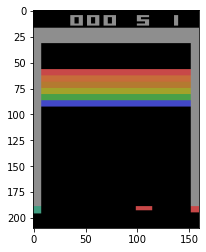

In [31]:
state= env.reset()
agent= DQNAgent(
    env= env, 
    env_name= 'Atari', 
    conv_net= True
)